# BoomBikes - Bike Sharing Assignment

**Objective:**  
Develop a multiple linear regression model to predict demand for shared bikes. This model will help BoomBikes, a U.S.-based bike-sharing provider, analyze demand factors and adapt its business strategy to increase profitability in the post-COVID market.

**Context:**  
BoomBikes has experienced revenue declines due to the COVID-19 pandemic. To prepare for increased demand as restrictions lift, the company has collected data on daily bike usage influenced by various factors. Understanding which variables most impact demand will enable BoomBikes to stand out among competitors by better meeting customer needs.

**Goal:**  
Analyze significant factors affecting bike demand and determine how well these variables predict demand. This insight will allow BoomBikes to fine-tune its strategies to better serve emerging demand trends and efficiently enter new markets.

In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import warnings
from IPython.display import display
from statsmodels.stats.stattools import durbin_watson

# Ignore warnings
warnings.filterwarnings('ignore')

In [5]:
# Read the dataset
bike = pd.read_csv("day.csv")

# Display the first few rows of the dataset
display(bike.head())

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Dataset Characteristics

**File:** `day.csv`

**Fields:**

- **instant:** Record index
- **dteday:** Date
- **season:** Season  
  - `1`: Spring  
  - `2`: Summer  
  - `3`: Fall  
  - `4`: Winter  
- **yr:** Year  
  - `0`: 2018  
  - `1`: 2019  
- **mnth:** Month (1 to 12)
- **holiday:** Whether the day is a holiday (data from [DCHR Holiday Schedule](http://dchr.dc.gov/page/holiday-schedule))
- **weekday:** Day of the week
- **workingday:** `1` if the day is neither a weekend nor a holiday, otherwise `0`
- **weathersit:** Weather situation  
  - `1`: Clear, Few clouds, Partly cloudy  
  - `2`: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
  - `3`: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
  - `4`: Heavy Rain + Ice Pellets + Thunderstorm + Mist, Snow + Fog  
- **temp:** Temperature in Celsius
- **atemp:** Feels-like temperature in Celsius
- **hum:** Humidity
- **windspeed:** Wind speed
- **casual:** Count of casual users
- **registered:** Count of registered users
- **cnt:** Total count of rental bikes, including both casual and registered users
```

## Exploratory Data Analysis

In [8]:
# Check for missing values in each column
print("="*50, "\n")
print("Missing Values in Each Column:\n")
print(bike.isnull().sum())
print("="*50, "\n")

# Display the number of unique values in each column
print("Number of Unique Values in Each Column:\n")
print(bike.nunique())
print("="*50)


Missing Values in Each Column:

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Number of Unique Values in Each Column:

instant       730
dteday        730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
casual        605
registered    678
cnt           695
dtype: int64


In [9]:
def create_and_concat_dummies(df, column_name, rename_dict, drop_first, drop_col=None):
    """
    Create dummy variables for a specified column, rename them, and concatenate to the original DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The original DataFrame.
    - column_name (str): Name of the column to create dummy variables from.
    - rename_dict (dict): Dictionary for renaming dummy columns.
    - drop_first (bool, optional): Whether to drop the first dummy column to avoid multicollinearity. Default is True.
    - drop_col (str, optional): Specific dummy column to drop after creation (useful for additional multicollinearity handling).
    
    Returns:
    - pd.DataFrame: DataFrame with dummy variables added.
    """
    # Create dummy variables
    dummies = pd.get_dummies(df[column_name], dtype=int, drop_first=drop_first)
    dummies.rename(columns=rename_dict, inplace=True)
    
    # Drop specified column, if any
    if drop_col and drop_col in dummies.columns:
        dummies.drop(columns=[drop_col], inplace=True)
    
    # Concatenate dummies to the original DataFrame and return
    return pd.concat([df, dummies], axis=1)

# Drop unnecessary columns
cleaned_bike = bike.drop(["instant", "dteday", "casual", "registered"], axis=1)

# Apply the function for each column that needs dummies
cleaned_bike = create_and_concat_dummies(cleaned_bike, "season", {2: "Summer", 3: "Fall", 4: "Winter"}, drop_first=True)
cleaned_bike = create_and_concat_dummies(cleaned_bike, "mnth", {
    2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}, drop_first=True)
cleaned_bike = create_and_concat_dummies(cleaned_bike, "weathersit", {1: "Clear", 2: "Mist", 3: "Light_Mist"}, drop_col="Light_Mist", drop_first=False)
cleaned_bike = create_and_concat_dummies(cleaned_bike, "weekday", {
    1: "Mon", 2: "Tues", 3: "Wed", 
    4: "Thurs", 5: "Fri", 6: "Sat"
}, drop_first=True)

# Display the first few rows of the updated DataFrame
display(cleaned_bike.head())

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,Nov,Dec,Clear,Mist,Mon,Tues,Wed,Thurs,Fri,Sat
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,...,0,0,0,1,0,0,0,0,0,1
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,...,0,0,0,1,0,0,0,0,0,0
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,...,0,0,1,0,1,0,0,0,0,0
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,...,0,0,1,0,0,1,0,0,0,0
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,...,0,0,1,0,0,0,1,0,0,0


In [10]:
def calculate_thi(temperature, humidity):
    """Calculates the Temperature-Humidity Index (THI)."""
    return 0.81 * temperature + 0.01 * humidity * (0.99 * temperature - 14.3)

def calculate_wind_chill(temperature, wind_speed):
    """Calculates the wind chill temperature."""
    return 13.12 + 0.6215 * temperature - 11.37 * wind_speed**0.16 + 0.3965 * temperature * wind_speed**0.16

def add_interaction_terms(df, interactions):
    """
    Adds interaction terms to the DataFrame based on specified column pairs.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to modify.
    - interactions (list of tuples): List of column pairs to interact.
    
    Returns:
    - pd.DataFrame: The modified DataFrame with interaction terms added.
    """
    for (col1, col2, new_col_name) in interactions:
        df[new_col_name] = df[col1] * df[col2]
    return df

# Add new calculated columns to cleaned_bike
cleaned_bike['thi'] = calculate_thi(cleaned_bike['temp'], cleaned_bike['hum'])
cleaned_bike['wind_chill'] = calculate_wind_chill(cleaned_bike['temp'], cleaned_bike['windspeed'])

# Define interaction terms to add
interactions = [
    ('temp', 'hum', 'temp_hum'),
    ('windspeed', 'temp', 'windspeed_temp'),
    ('holiday', 'weekday', 'holiday_weekday')
]

# Add interaction terms
cleaned_bike = add_interaction_terms(cleaned_bike, interactions)

# Display the columns in the DataFrame
print("\nFirst few rows of the dataset:")
display(cleaned_bike.head())


First few rows of the dataset:


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,Tues,Wed,Thurs,Fri,Sat,thi,wind_chill,temp_hum,windspeed_temp,holiday_weekday
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,...,0,0,0,0,1,11.163650,13.445268,1137.098617,151.689940,0
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,...,0,0,0,0,0,12.386830,13.817173,1037.350473,248.159746,0
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,...,0,0,0,0,0,3.753492,5.300116,352.045169,133.940831,0
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,...,1,0,0,0,0,2.991931,6.346426,484.156700,88.066622,0
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,...,0,1,0,0,0,5.314085,7.394738,406.598844,116.522969,0


In [11]:
# Define variable groups
categorical_vars = ['holiday', 'workingday', 'holiday_weekday', 'yr', 'weathersit']
numerical_vars = ['temp', 'atemp', 'thi', 'hum', 'windspeed', 'wind_chill', 'temp_hum', 'windspeed_temp']
season_vars = ['Summer', 'Fall', 'Winter']
weather_vars = ['Clear', 'Mist']
month_vars = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days_vars = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']

def configure_plot():
    """Set plot configurations for consistency across functions."""
    sns.set_palette("tab10", 8)
    plt.figure(figsize=(20, 12))

def plot_univariate_line(x_vars, df_data, y_var="cnt", tick_size=12, label_size=14):
    configure_plot()
    num_plots = len(x_vars)
    for i, var in enumerate(x_vars):
        plt.subplot(2, 2, i + 1)
        var_group_cnt = df_data.groupby([var])[y_var].mean()
        sns.lineplot(x=var_group_cnt.index, y=var_group_cnt.values, marker='o')
        plt.xlabel(var, fontsize=label_size)
        plt.ylabel("Mean Count", fontsize=label_size)
        plt.xticks(fontsize=tick_size)
        plt.yticks(fontsize=tick_size)
    plt.tight_layout()
    plt.show()

def plot_figure_box(x_vars, y_var, df_data, hue=None, tick_size=12, label_size=14):
    configure_plot()
    num_plots = len(x_vars)
    for i, var in enumerate(x_vars):
        plt.subplot((num_plots + 2) // 3, 3, i + 1)
        sns.boxplot(x=var, y=y_var, data=df_data, hue=hue)
        plt.xlabel(var, fontsize=label_size)
        plt.ylabel(y_var, fontsize=label_size)
        plt.xticks(fontsize=tick_size)
        plt.yticks(fontsize=tick_size)
    plt.tight_layout()
    plt.show()

def plot_figure_scatter(x_vars, y_var, df_data, hue=None, tick_size=12, label_size=14):
    configure_plot()
    num_plots = len(x_vars)
    for i, var in enumerate(x_vars):
        plt.subplot((num_plots + 2) // 3, 3, i + 1)
        sns.scatterplot(x=var, y=y_var, data=df_data, hue=hue)
        plt.xlabel(var, fontsize=label_size)
        plt.ylabel(y_var, fontsize=label_size)
        plt.xticks(fontsize=tick_size)
        plt.yticks(fontsize=tick_size)
    plt.tight_layout()
    plt.show()

# Correlation heatmap function
def correlation(vars, df_data, title="Correlation Matrix"):
    corr_vars = vars + ['cnt']
    corr = df_data[corr_vars].corr()
    plt.figure(figsize=(10, 5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(title, fontsize=16)
    plt.show()

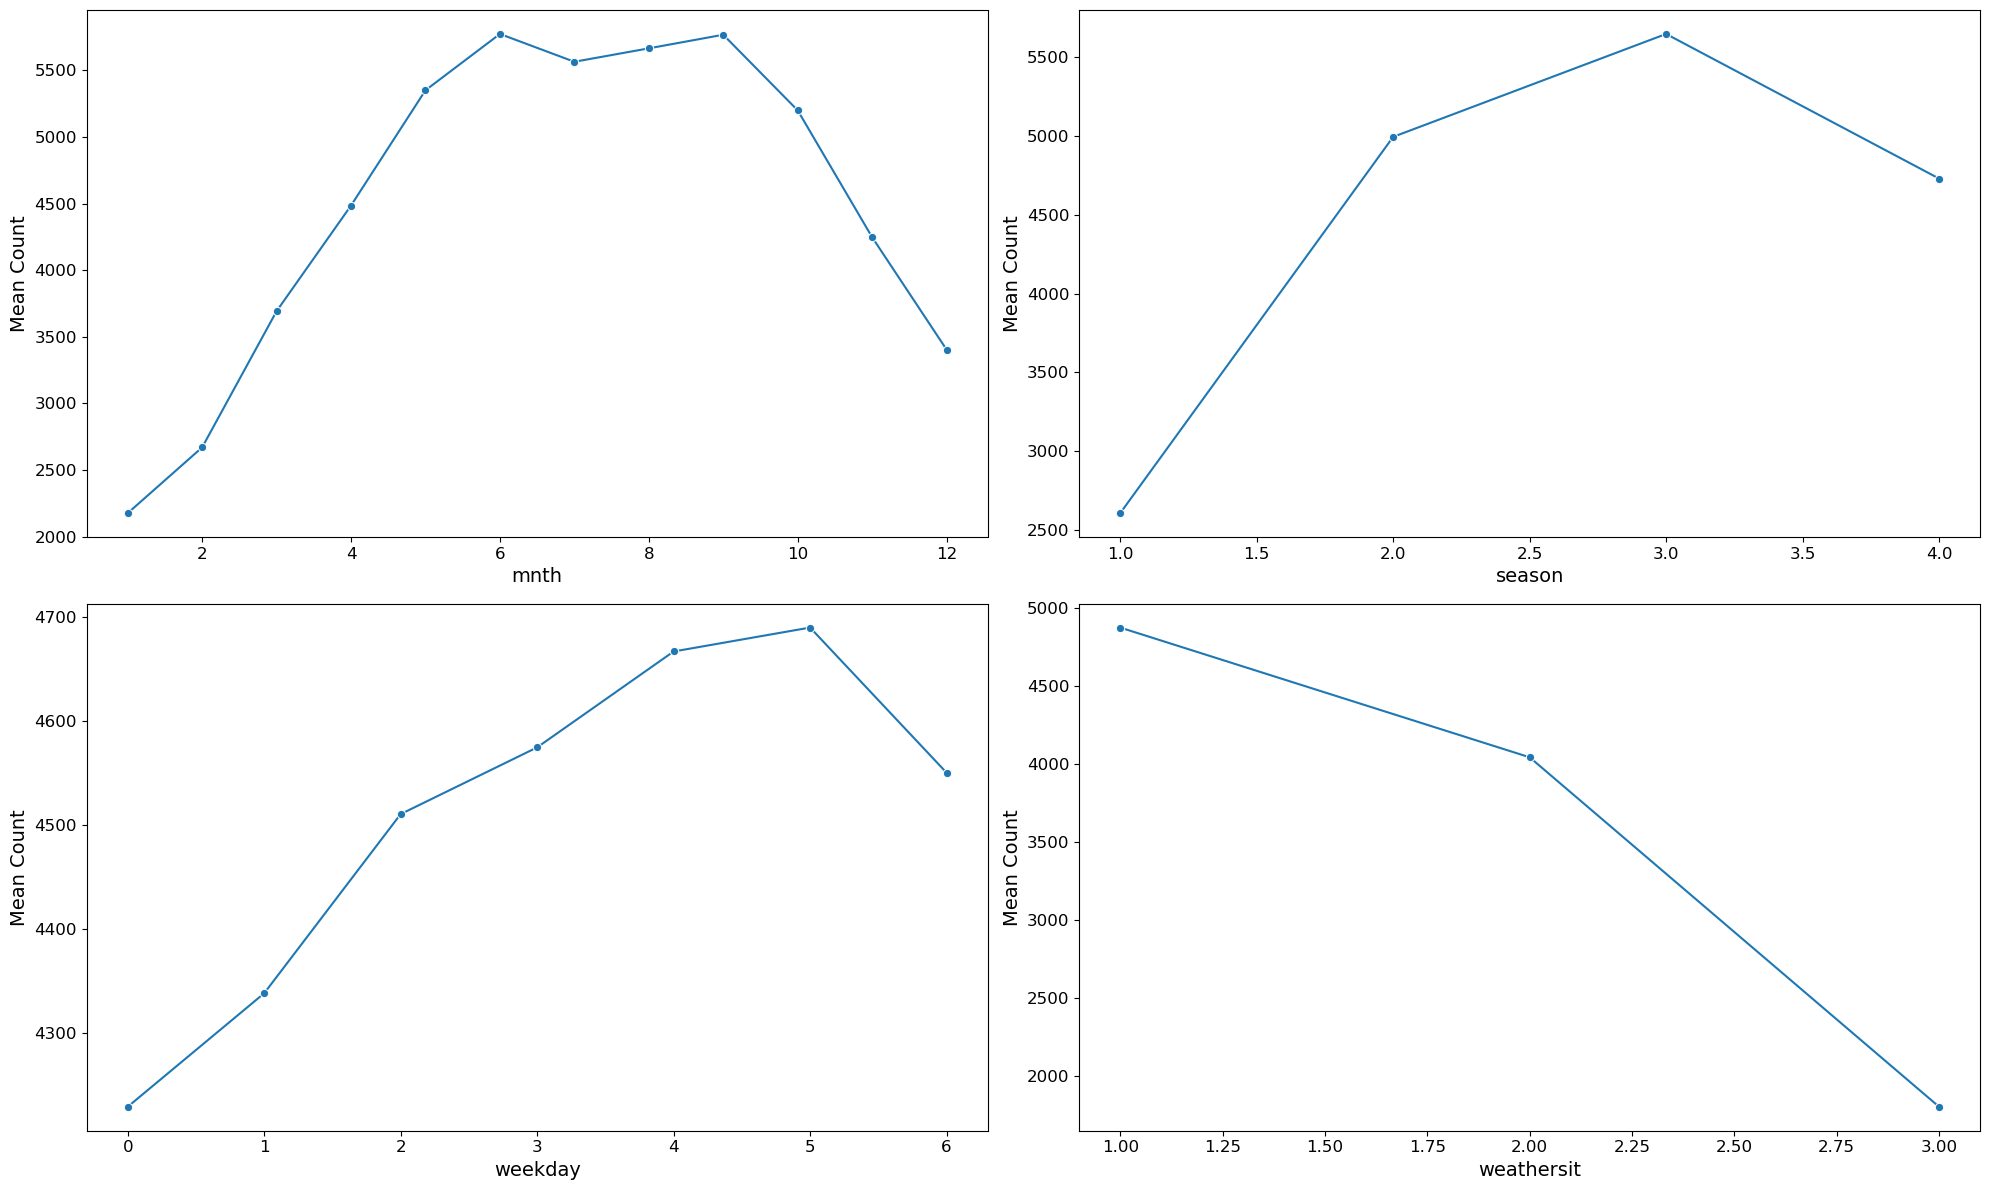

In [12]:
# Example usage
plot_univariate_line(x_vars=["mnth", "season", "weekday", "weathersit"], df_data=cleaned_bike)

#### Month vs Mean Count
- This line plot shows the mean count of bike rentals across different months. There's a clear seasonal pattern, with peaks in the summer months and troughs in the winter.

#### Season vs Mean Count
- This line plot shows the mean count of bike rentals across different seasons. We see a distinct seasonal trend, with the highest rentals in the summer and the lowest in the winter.

#### Weekday vs Mean Count
- This line plot illustrates the mean count of bike rentals on different weekdays. There's a clear pattern, with higher rentals on weekdays (likely due to commuting) and lower rentals on weekends.

#### Weathersit vs Mean Count
- This line plot shows the mean count of bike rentals across different weather situations. We observe a decrease in rentals as the weather worsens, with the lowest count in the worst weather condition.

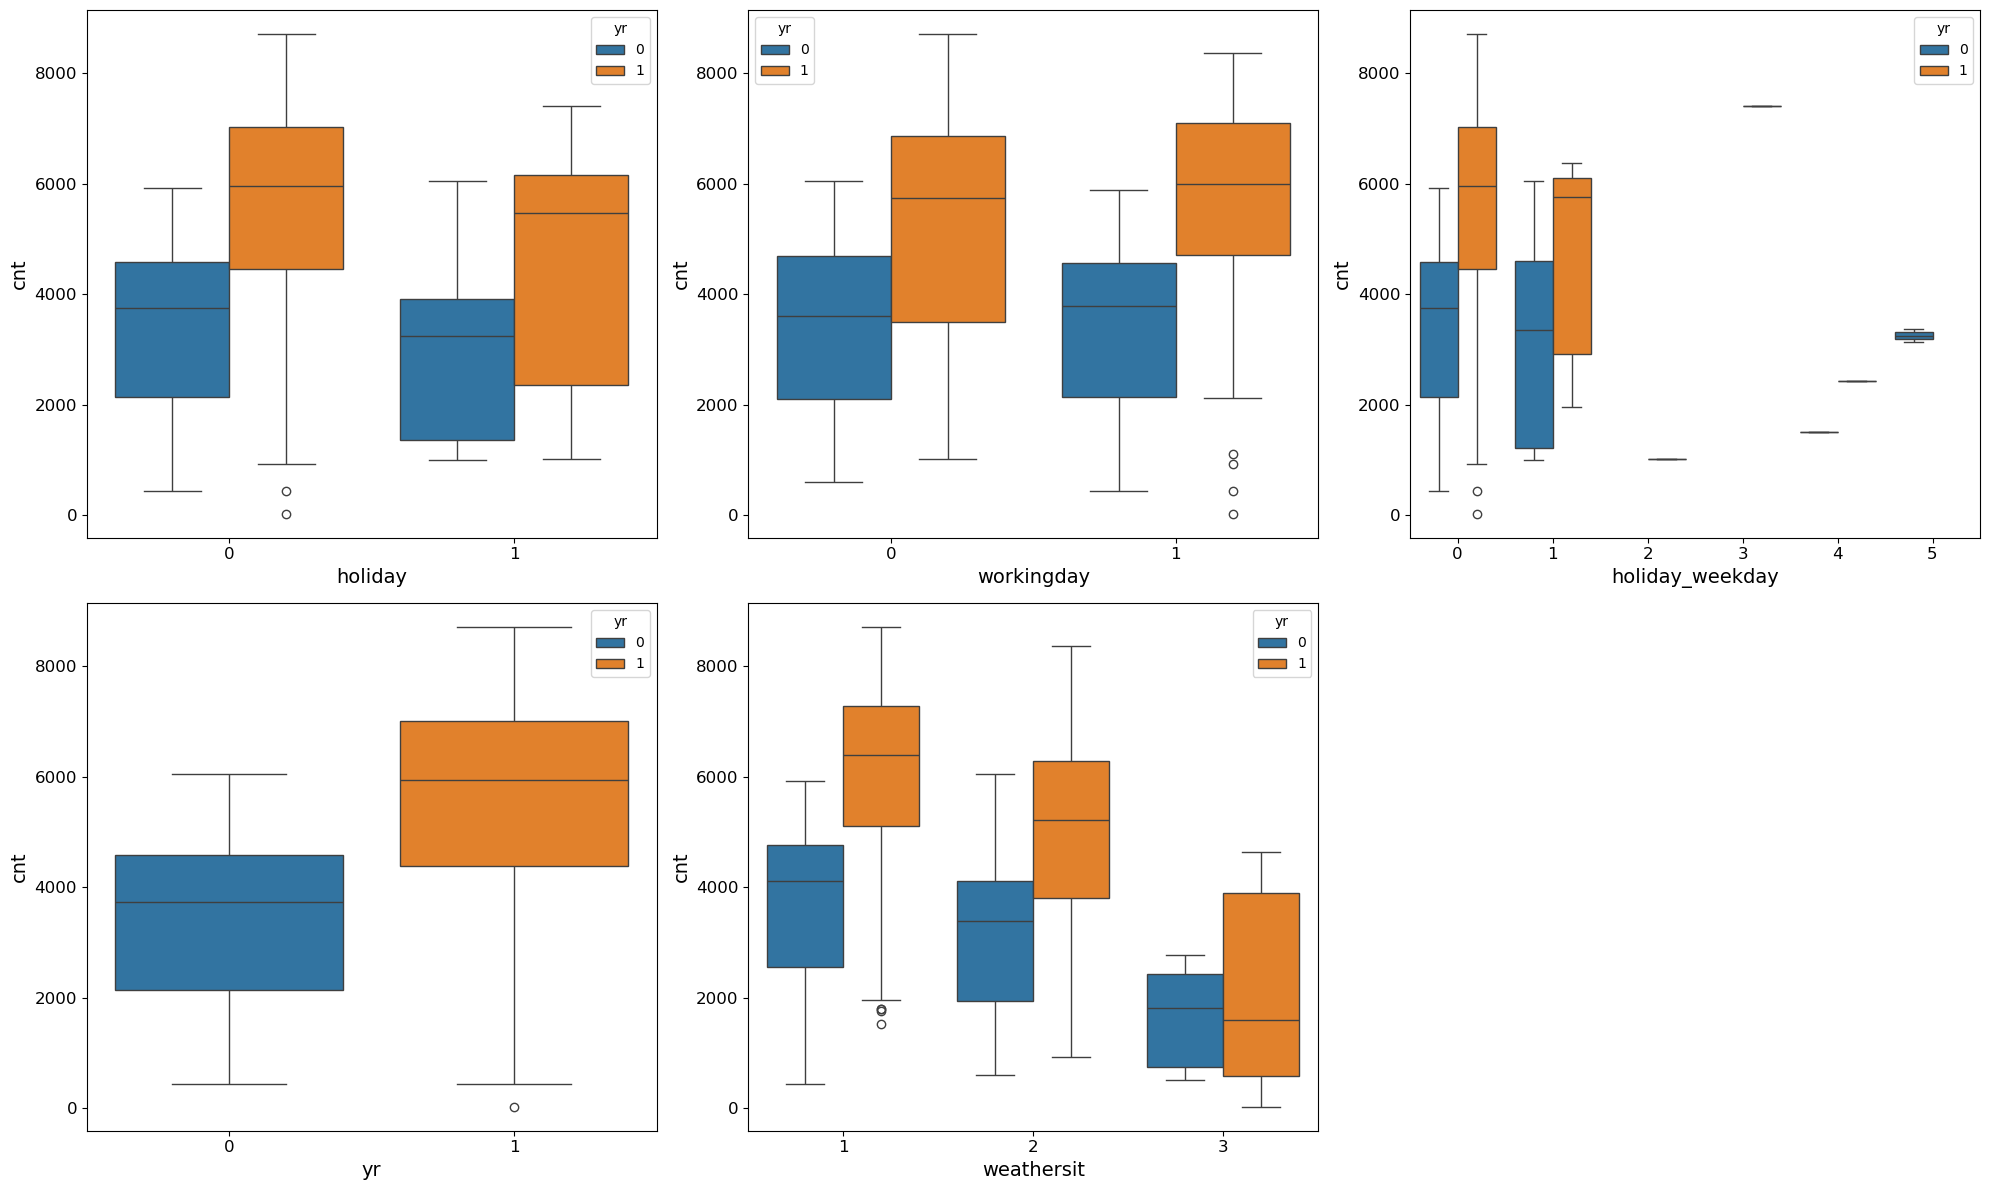

In [14]:
# Generate the plots
plot_figure_box(x_vars=categorical_vars, y_var="cnt", df_data=cleaned_bike, hue='yr')

#### Holiday vs Mean Count
- This box plot shows the mean count of bike rentals on holidays and non-holidays. We observe a slight increase in rentals on holidays compared to non-holidays.

#### Workingday vs Mean Count
- This box plot shows the mean count of bike rentals on working days and non-working days. We see that rentals are significantly higher on working days compared to non-working days.

#### Holiday_weekday vs Mean Count
- This box plot shows the mean count of bike rentals on different combinations of holidays and weekdays. We observe the highest rentals on non-holidays and weekdays.

#### Weathersit vs Mean Count
- This box plot shows the mean count of bike rentals in different years. We see a slight increase in rentals from year 0 to year 1.

#### Weathersit vs Mean Count
- This box plot shows the mean count of bike rentals across different weather situations. We observe a decrease in rentals as the weather worsens, with the lowest count in the worst weather condition.

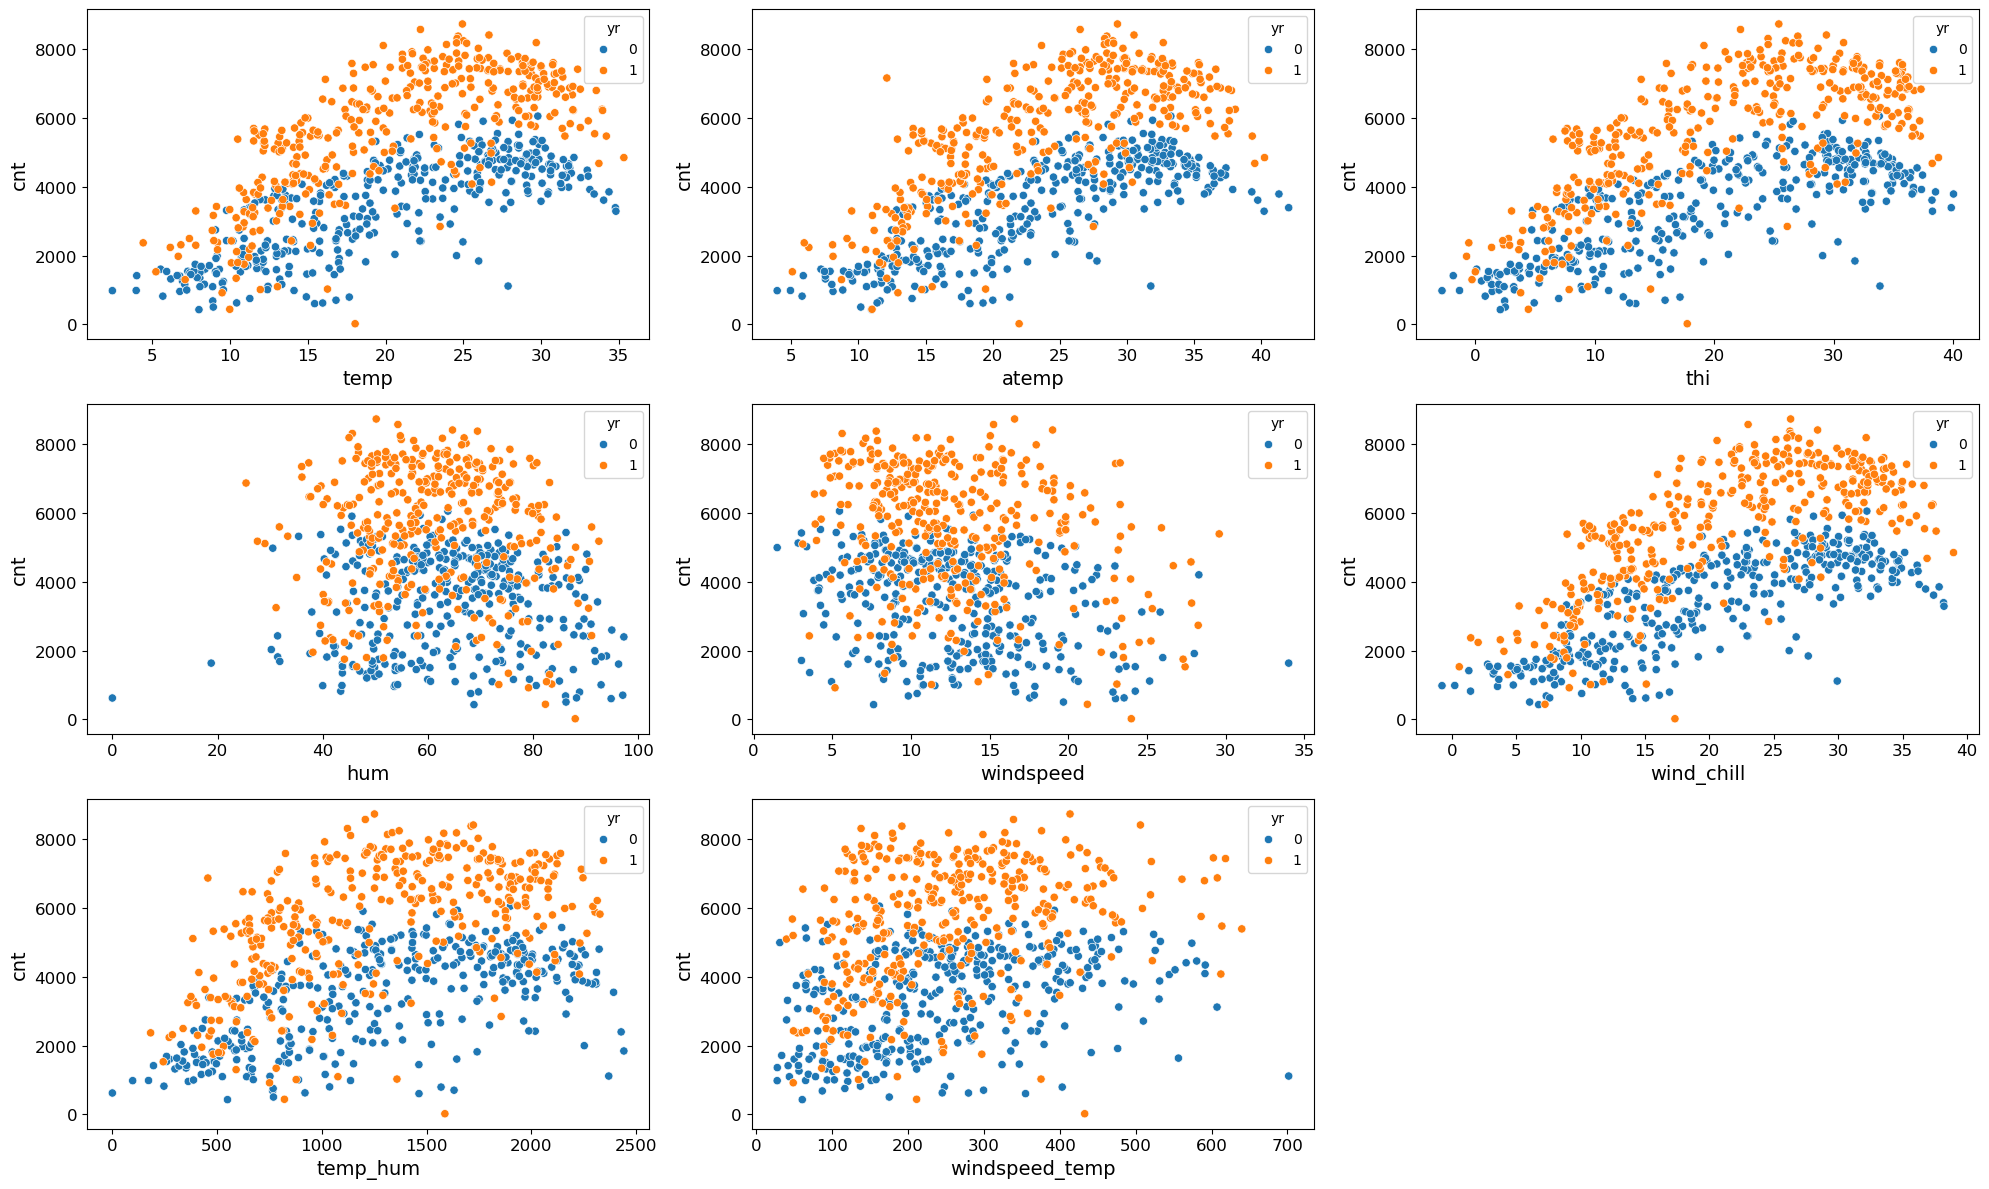

In [16]:
# Generate the plots
plot_figure_scatter(x_vars=numerical_vars, y_var='cnt', df_data=cleaned_bike, hue='yr')

#### Temperature vs Mean Count
- This scatter plot shows the mean count of bike rentals across different temperature values. We observe a positive correlation between temperature and bike rentals, with higher rentals on warmer days.

#### Atemp vs Mean Count
- This scatter plot shows the mean count of bike rentals across different apparent temperature values. Similar to temperature, we see a positive correlation between apparent temperature and bike rentals.

#### THI vs Mean Count
- This scatter plot shows the mean count of bike rentals across different Temperature-Humidity Index (THI) values. We observe a positive correlation between THI and bike rentals, with higher rentals on days with higher THI values. The plot also shows a slight separation between the two classes (likely representing different years), indicating that the relationship between THI and bike rentals might have changed over time.

#### Hum vs Mean Count
- This scatter plot shows the mean count of bike rentals across different humidity values. We observe a slight negative correlation between humidity and bike rentals, with slightly lower rentals on days with higher humidity.

#### Windspeed vs Mean Count
- This scatter plot shows the mean count of bike rentals across different windspeed values. We observe a slight negative correlation between windspeed and bike rentals, with slightly lower rentals on days with higher windspeed.

#### Windchill vs Mean Count
- This scatter plot shows the mean count of bike rentals across different windchill values. We observe a slight negative correlation between windchill and bike rentals, with slightly lower rentals on days with lower windchill.

#### Temperature vs Humidity vs Mean Count
- This 3D scatter plot shows the mean count of bike rentals across different combinations of temperature and humidity values. We observe a positive correlation between temperature and bike rentals, and a slight negative correlation between humidity and bike rentals.

#### Wind Speed * Temperature vs Mean Count
- This scatter plot shows the mean count of bike rentals across different values of the interaction term between wind speed and temperature. We observe a complex relationship, with some clusters of high rentals and some clusters of low rentals. The plot also shows a slight separation between the two classes (likely representing different years), indicating that the relationship between this interaction term and bike rentals might have changed over time.

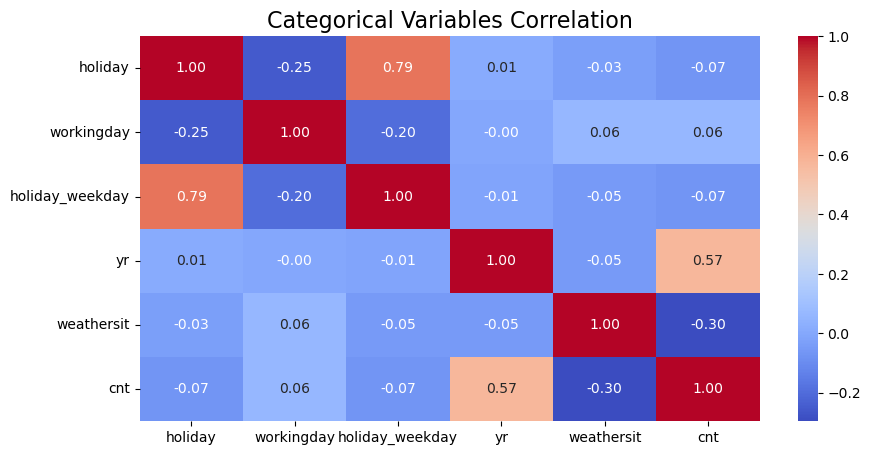

In [18]:
# Display correlation matrices with titles for each group of variables
correlation(vars=categorical_vars, df_data=cleaned_bike, title="Categorical Variables Correlation")

#### Categorical Variables Correlation

This heatmap shows the correlation matrix between the categorical variables in the dataset. We can observe the following:

- **Holiday and Holiday_weekday** are highly correlated (0.79), indicating a strong positive relationship.
- **Workingday and Holiday** are negatively correlated (-0.25), indicating an inverse relationship.
- **Year and Count** are positively correlated (0.57), indicating that the number of bike rentals has increased over the years.
- **Weathersit and Count** are negatively correlated (-0.30), indicating that the number of bike rentals decreases as the weather worsens.

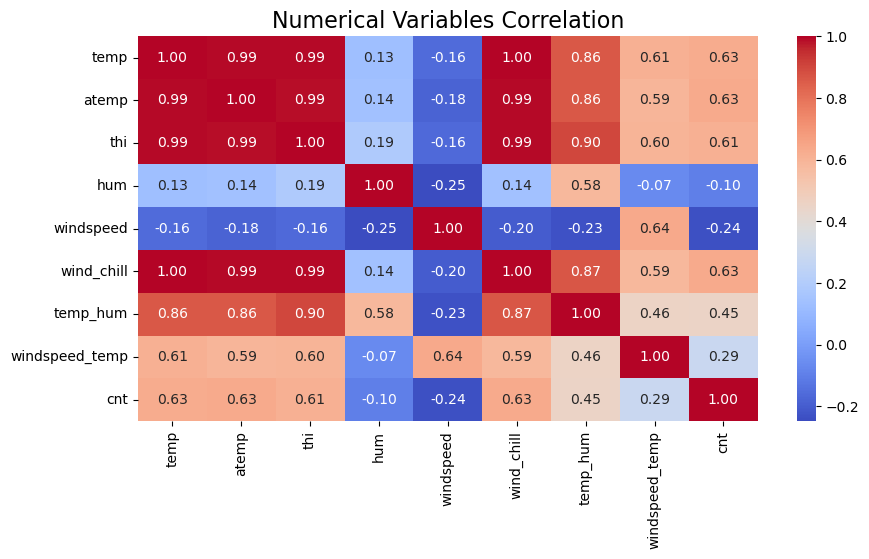

In [20]:
correlation(vars=numerical_vars, df_data=cleaned_bike, title="Numerical Variables Correlation")

#### Numerical Variables Correlation

This heatmap shows the correlation matrix between the numerical variables in the dataset. We can observe the following:

- **Temperature, Apparent Temperature, and Temperature-Humidity Index (THI)** are highly correlated with each other (0.99, 0.99, and 1.00 respectively), indicating that these variables are almost perfectly linearly related.
- **Temperature, Apparent Temperature, and THI** are also positively correlated with **Count** (0.63, 0.63, and 0.61 respectively), suggesting that higher temperatures and THI values are associated with higher bike rentals.
- **Humidity** is negatively correlated with **Count** (-0.10), indicating that higher humidity levels might slightly decrease bike rentals.
- **Windspeed and Windchill** are negatively correlated with **Count** (-0.24 and -0.24), suggesting that higher wind speeds and colder wind chills might slightly decrease bike rentals.
- **The interaction term between wind speed and temperature (windspeed_temp)** has a moderate positive correlation with **Count** (0.29), indicating that this interaction term might have some influence on bike rentals.

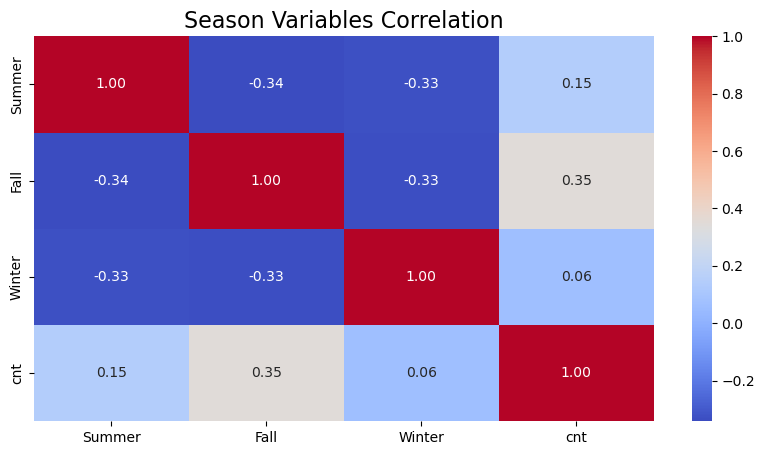

In [22]:
correlation(vars=season_vars, df_data=cleaned_bike, title="Season Variables Correlation")

#### Season Variables Correlation

This heatmap shows the correlation matrix between the seasonal variables in the dataset. We can observe the following:

- **Winter and Fall** are negatively correlated (-0.33), suggesting that an increase in one season is associated with a decrease in the other.
- **Summer and Fall** are negatively correlated (-0.34), suggesting a similar relationship.
- **Summer and Count** are positively correlated (0.15), indicating that bike rentals might be slightly higher in the summer compared to other seasons.
- **Winter and Count** are negatively correlated (-0.33), suggesting that bike rentals might be lower in the winter compared to other seasons.

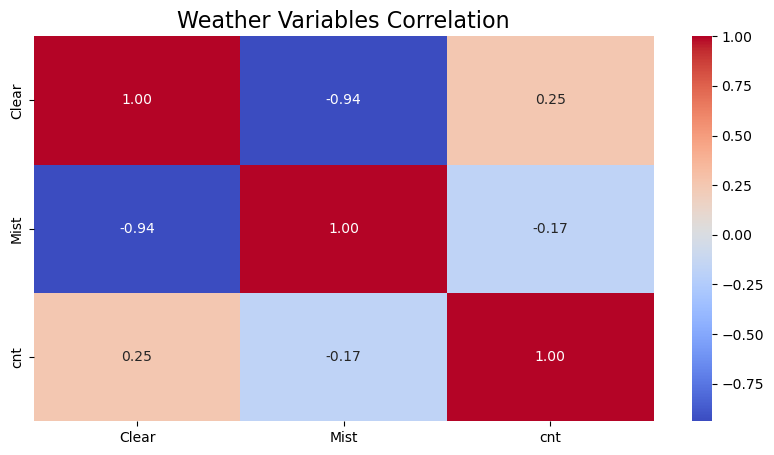

In [24]:
correlation(vars=weather_vars, df_data=cleaned_bike, title="Weather Variables Correlation")

#### Weather Variables Correlation

This heatmap shows the correlation matrix between the weather variables in the dataset. We can observe the following:

- **Clear and Mist** are strongly negatively correlated (-0.94), indicating that if it's clear, it's unlikely to be misty, and vice versa.
- **Clear and Count** are positively correlated (0.25), suggesting that bike rentals might be slightly higher on clear days.
- **Mist and Count** are negatively correlated (-0.17), suggesting that bike rentals might be slightly lower on misty days.

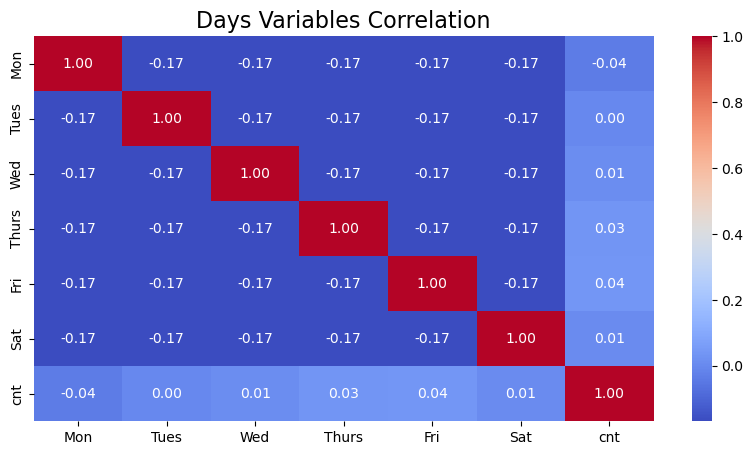

In [26]:
correlation(vars=days_vars, df_data=cleaned_bike, title="Days Variables Correlation")

#### Days Variables Correlation

This heatmap shows the correlation matrix between the day-related variables in the dataset. We can observe the following:

- The days of the week (Mon-Sat) are not strongly correlated with each other, indicating that there is no significant relationship between them.
- There is a very weak positive correlation between the days of the week and the count of bike rentals, suggesting that there might be a slight trend in rental patterns across different days. However, this correlation is very weak and likely not significant.

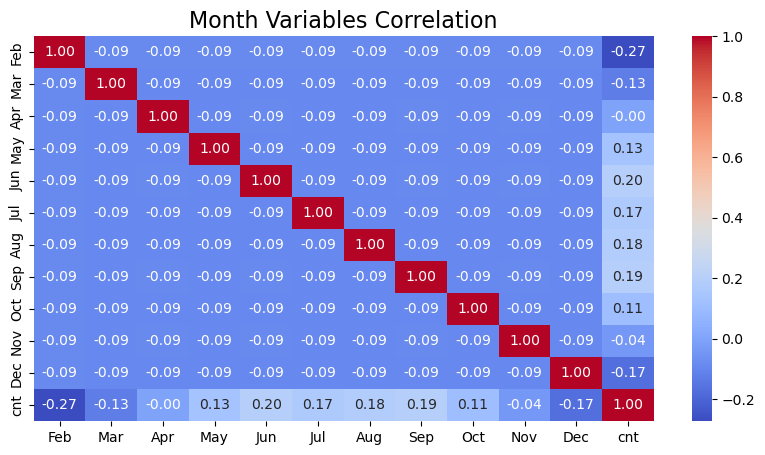

In [28]:
correlation(vars=month_vars, df_data=cleaned_bike, title="Month Variables Correlation")

#### Month Variables Correlation

This heatmap shows the correlation matrix between the month-related variables in the dataset. We can observe the following:

- The months of the year are not strongly correlated with each other, indicating that there is no significant relationship between them.
- There is a weak negative correlation between December and Count (-0.27), suggesting that bike rentals might be slightly lower in December compared to other months.
- There is a weak positive correlation between June and Count (0.20), suggesting that bike rentals might be slightly higher in June compared to other months.

## Train Test Split

In [31]:
# Split the data into training and testing sets
df_train, df_test = train_test_split(cleaned_bike, train_size=0.7, random_state=100)

# Display the shape of the resulting DataFrames
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (510, 39)
Test shape: (220, 39)


## Feature Scaling for train data

In [33]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler() 

# Define the variables to be scaled
scaled_vars = numerical_vars + ['cnt']

# Fit the scaler on the training set and transform both train and test sets
df_train[scaled_vars] = scaler.fit_transform(df_train[scaled_vars])
df_test[scaled_vars] = scaler.transform(df_test[scaled_vars])

In [34]:
# Display the first few rows of the scaled training data
print("First few rows of the scaled training data:")
display(df_train[scaled_vars].head())

# Display the first few rows of the scaled test data
print("\nFirst few rows of the scaled test data:")
display(df_test[scaled_vars].head())

First few rows of the scaled training data:


,temp,atemp,thi,hum,windspeed,wind_chill,temp_hum,windspeed_temp,cnt
576,0.815169,0.766351,0.862846,0.725633,0.264686,0.815757,0.843357,0.439690,0.827658
426,0.442393,0.438975,0.424582,0.640189,0.255342,0.444538,0.432002,0.230560,0.465255
728,0.245101,0.200348,0.220367,0.498067,0.663106,0.212858,0.207609,0.324426,0.204096
482,0.395666,0.391735,0.370164,0.504508,0.188475,0.404535,0.309619,0.158159,0.482973
111,0.345824,0.318819,0.316816,0.751824,0.380981,0.337349,0.412400,0.259884,0.191095



First few rows of the scaled test data:


,temp,atemp,thi,hum,windspeed,wind_chill,temp_hum,windspeed_temp,cnt
184,0.831783,0.769660,0.858561,0.657364,0.084219,0.830578,0.778293,0.199957,0.692706
535,0.901354,0.842587,0.917160,0.610133,0.153728,0.898848,0.777876,0.321667,0.712034
299,0.511964,0.496145,0.522524,0.837699,0.334206,0.509226,0.641487,0.337532,0.303382
221,0.881625,0.795343,0.829703,0.437098,0.339570,0.883322,0.545993,0.584555,0.547400
152,0.817246,0.741471,0.727494,0.314298,0.537414,0.818723,0.366142,0.810666,0.569029


In [35]:
# Separate the target variable 'cnt' from the training data
y_train = df_train.pop('cnt')
X_train = df_train

## Model 1

In [37]:
# Define features to use 
features_used = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 
                 'temp', 'atemp', 'hum', 'windspeed'] 

# Select features from training data 
X_train_1 = X_train[features_used] 
y_train_1 = y_train 

# Initialize and fit Linear Regression model 
lm = LinearRegression() 
lm.fit(X_train_1, y_train_1) 

# Apply Recursive Feature Elimination (RFE) 
rfe = RFE(lm, n_features_to_select=10) 
rfe = rfe.fit(X_train_1, y_train_1) 

# Create list of features with support and ranking, and sort by ranking 
features = list(zip(X_train_1.columns, rfe.support_, rfe.ranking_)) 
sorted_features = sorted(features, key=lambda x: x[2]) 

# Display sorted features 
sorted_features

[('season', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('weekday', True, 1),
 ('workingday', True, 1),
 ('weathersit', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('mnth', False, 2)]

In [38]:
# Select columns from the original training data that were supported by RFE
col = X_train_1.columns[rfe.support_]

# Create a new DataFrame with the selected columns
X_train_1_rfe = X_train_1[col]

# Display the first few rows of the new DataFrame
display(X_train_1_rfe.head())

,season,yr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
576,3,1,0,2,1,1,0.815169,0.766351,0.725633,0.264686
426,1,1,0,6,0,2,0.442393,0.438975,0.640189,0.255342
728,1,1,0,0,0,1,0.245101,0.200348,0.498067,0.663106
482,2,1,0,6,0,2,0.395666,0.391735,0.504508,0.188475
111,2,0,0,5,1,2,0.345824,0.318819,0.751824,0.380981


In [39]:
def vif_calc(df_data):
    # Create an empty DataFrame to store VIF values
    vif = pd.DataFrame()
    vif["Features"] = df_data.columns
    
    # Calculate VIF for each feature
    vif["VIF"] = [variance_inflation_factor(df_data.values, i) for i in range(df_data.shape[1])]
    vif["VIF"] = round(vif["VIF"], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    
    # Print the VIF DataFrame
    print(vif)

In [40]:
# Add a constant to the features DataFrame
X_train_1_rfe = sm.add_constant(X_train_1_rfe)

# Fit the OLS regression model
lm = sm.OLS(y_train_1, X_train_1_rfe).fit()

# Print the summary of the regression model and VIF values
print(lm.summary())
vif_calc(X_train_1_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     204.5
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.29e-169
Time:                        14:28:55   Log-Likelihood:                 454.24
No. Observations:                 510   AIC:                            -886.5
Df Residuals:                     499   BIC:                            -839.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2160      0.030      7.202      0.0

In [41]:
# Drop the 'atemp' column from the features DataFrame because of High VIF
X_train_1_rfe = X_train_1_rfe.drop(["atemp"], axis=1)

X_train_1_rfe = sm.add_constant(X_train_1_rfe)
lm = sm.OLS(y_train_1, X_train_1_rfe).fit()
print(lm.summary())
vif_calc(X_train_1_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     225.6
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          8.77e-170
Time:                        14:28:55   Log-Likelihood:                 452.41
No. Observations:                 510   AIC:                            -884.8
Df Residuals:                     500   BIC:                            -842.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2220      0.030      7.423      0.0

### Prediction

In [43]:
# Predict the training set using the fitted model
y_train_1_pred = lm.predict(X_train_1_rfe)

# Calculate the residuals for the training set
train_res_1 = y_train_1 - y_train_1_pred

Linearity Check
- Using scatter plots for each predictor against the target variable to visually inspect linearity:

In [45]:
def linearity_check_plot(residuals_train, residuals_test, y_train_pred, y_test_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train_pred, residuals_train, color='blue', alpha=0.6, label='Train Data')
    plt.scatter(y_test_pred, residuals_test, color='orange', alpha=0.6, label='Test Data')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual plot for linearity check')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

Independence Check
- Using the Durbin-Watson test on the residuals
- Values between 1.5 and 2.5 suggest no significant autocorrelation.

In [47]:
# Durbin-Watson test
def independence_check_plot(residuals_train, residuals_test):
    dw_train = durbin_watson(residuals_train)
    dw_test = durbin_watson(residuals_test)
    print(f'Durbin-Watson statistic (Train): {dw_train}')
    print(f'Durbin-Watson statistic (Test): {dw_test}')

Homoscedasticity Check
- Using a residuals vs. predicted values plot to assess constant variance:

In [49]:
def homoscedasticity_check_plot(residuals_train, residuals_test, y_train_pred, y_test_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train_pred, residuals_train, color='blue', alpha=0.6, label='Train Data')
    plt.scatter(y_test_pred, residuals_test, color='orange', alpha=0.6, label='Test Data')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Homoscedasticity check')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

Normality of Errors
- Histogram and Q-Q plot of residuals

In [51]:
def normality_check_plot(residuals_train, residuals_test):
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals_train, kde=True, color='blue', label='Train Data')
    sns.histplot(residuals_test, kde=True, color='orange', label='Test Data', alpha=0.6)
    plt.title('Histogram of residuals')
    plt.xlabel('Residuals')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(8, 6))
    sm.qqplot(residuals_train, line='45')
    plt.title('Q-Q plot of residuals (Train Data)')
    plt.show()
    
    plt.figure(figsize=(8, 6))
    sm.qqplot(residuals_test, line='45')
    plt.title('Q-Q plot of residuals (Test Data)')
    plt.show()

In [52]:
def metrics(y_train, y_train_pred, y_test, y_test_pred, final_data):
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_r2 = r2_score(y_test, y_test_pred)
    
    features_used = final_data.columns.to_list()[1:]
    
    print("="*60) 
    print("Features used:", features_used) 
    print("="*60) 
    print("\nTraining Set Metrics:") 
    print("="*60) 
    print(f"Mean Squared Error (MSE): {train_mse}") 
    print(f"Root Mean Squared Error (RMSE): {train_rmse}") 
    print(f"R-squared Score: {train_r2}") 
    print("="*60) 
    print("\nTest Set Metrics:") 
    print("="*60) 
    print(f"Mean Squared Error (MSE): {test_mse}") 
    print(f"Root Mean Squared Error (RMSE): {test_rmse}") 
    print(f"R-squared Score: {test_r2}")

In [53]:
# Separate the target variable from the test set
y_test_1 = df_test.pop('cnt')
X_test = df_test

# Select the same features as used in training (excluding the constant)
X_test_1 = X_test[X_train_1_rfe.columns.to_list()[1:]]
X_test_1 = sm.add_constant(X_test_1)
y_test_1_pred = lm.predict(X_test_1)

# Calculate the residuals for the test set
test_res_1 = y_test_1 - y_test_1_pred

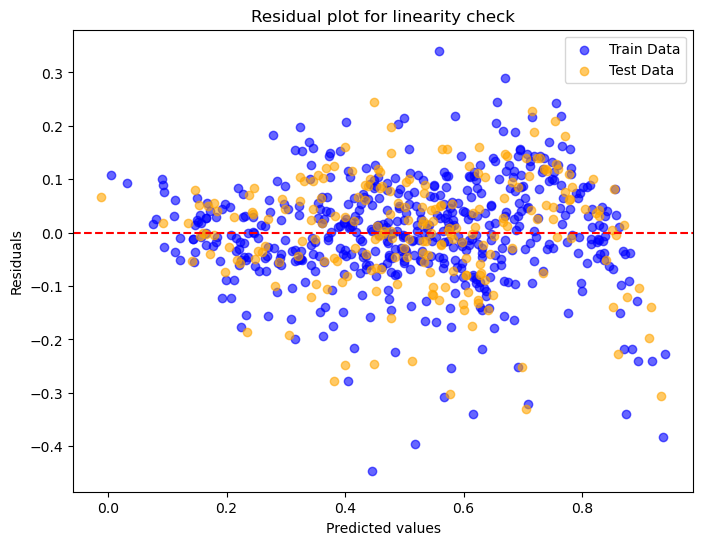

In [54]:
linearity_check_plot(residuals_train=train_res_1, residuals_test=test_res_1, 
                     y_train_pred=y_train_1_pred, y_test_pred=y_test_1_pred)

#### Residual Plot for Linearity Check

This residual plot helps assess the linearity assumption of the model. Ideally, the residuals should be randomly scattered around the horizontal line at zero. In this plot, we can observe:

The plot shows no clear pattern, indicating that the linear regression model's assumptions of linearity are likely met. The residuals are randomly scattered around zero, suggesting that the model's predictions are accurate across the range of predicted values.

In [56]:
independence_check_plot(residuals_train=train_res_1, residuals_test=test_res_1)

Durbin-Watson statistic (Train): 2.00606786180745
Durbin-Watson statistic (Test): 1.8511636533066453


#### Independence Check 

The Durbin-Watson statistic for both the train and test sets is close to 2, indicating that there is no significant autocorrelation in the residuals. This suggests that the residuals are independent of each other.


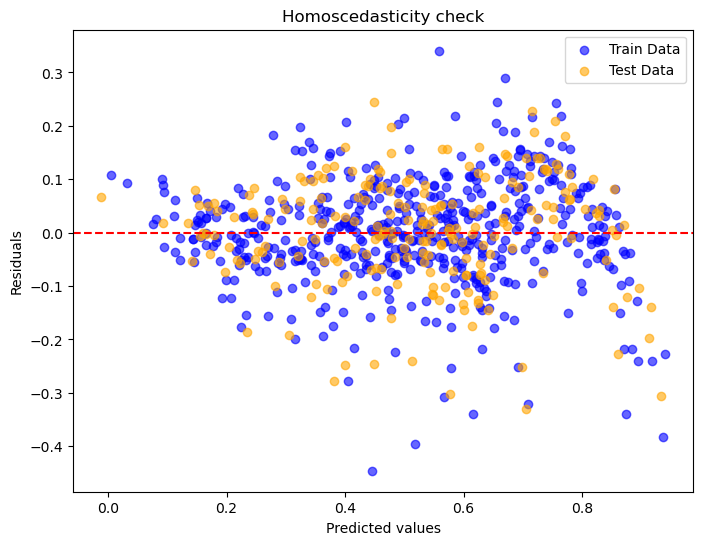

In [58]:
homoscedasticity_check_plot(residuals_train=train_res_1, residuals_test=test_res_1, 
                            y_train_pred=y_train_1_pred, y_test_pred=y_test_1_pred)

#### Homoscedasticity Check

The plot shows that the residuals are randomly scattered around the horizontal line at zero, with no apparent pattern in their spread. This suggests that the model's error variance is relatively constant across different predicted values.

Overall, the plots suggest that the independence and homoscedasticity assumptions are reasonably met by the model.

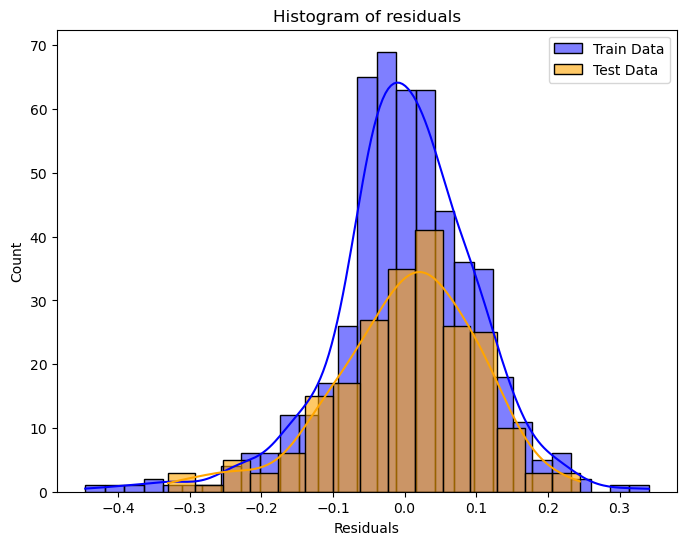

<Figure size 800x600 with 0 Axes>

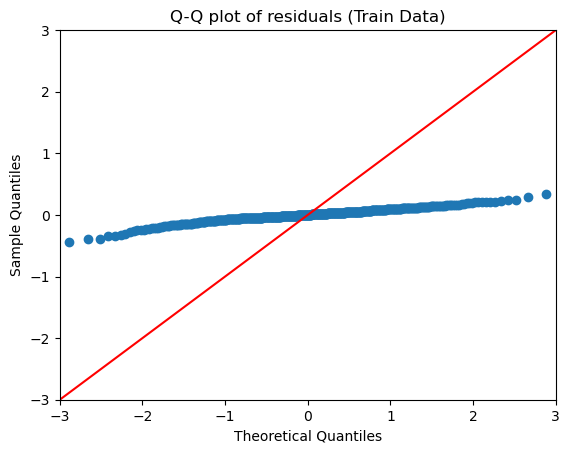

<Figure size 800x600 with 0 Axes>

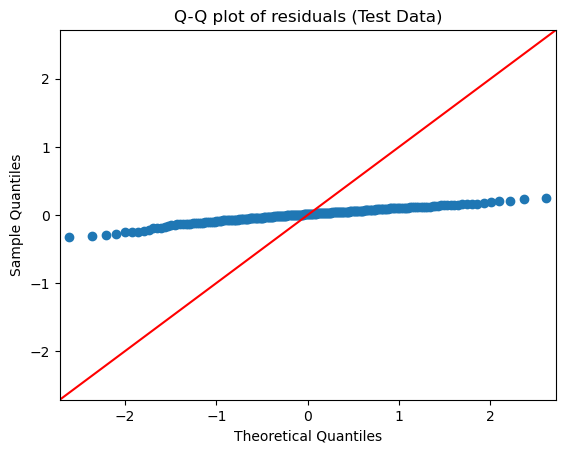

In [60]:
normality_check_plot(residuals_train=train_res_1, residuals_test=test_res_1)

#### Normality check for the Residuals of Train and Test Data

This histogram shows the distribution of residuals for both the train and test data. Ideally, the residuals should be normally distributed. In this plot, we can observe:

The histogram shows the distribution of residuals for both training and test data. Both distributions appear approximately bell-shaped, suggesting that the residuals are normally distributed. This assumption of normality is essential for making valid inferences about the model's performance and for applying statistical tests.

**Q-Q Plot of Residuals (Train Data)**

This Q-Q plot helps assess the normality assumption of the model's residuals. Ideally, the points should follow a straight line. In this plot, we can observe:

- **Some deviation from normality:** The points deviate slightly from the straight line, especially in the tails. This suggests that the residuals might not be perfectly normally distributed.

**Q-Q Plot of Residuals (Test Data)**

This Q-Q plot helps assess the normality assumption of the model's residuals on the test data. Ideally, the points should follow a straight line. In this plot, we can observe:

- **Reasonable normality:** The points follow the straight line fairly well, suggesting that the residuals are approximately normally distributed.

Overall, while the normality assumption might not be perfectly met for the train data, the test data seems to have reasonably normally distributed residuals. It's worth considering transformations or more robust modeling techniques if the normality assumption is a major concern.

In [62]:
metrics(y_train_1, y_train_1_pred, y_test_1, y_test_1_pred, X_train_1_rfe)

Features used: ['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed']

Training Set Metrics:
Mean Squared Error (MSE): 0.00993152998218204
Root Mean Squared Error (RMSE): 0.09965706187813306
R-squared Score: 0.802420389921035

Test Set Metrics:
Mean Squared Error (MSE): 0.010336110588984832
Root Mean Squared Error (RMSE): 0.10166666409883247
R-squared Score: 0.7838279548399095


#### Model Evaluation Metrics

**Interpretation:**

- **MSE and RMSE:** These metrics measure the average squared difference between the predicted and actual values. Lower values indicate better model performance. In this case, the model performs slightly better on the training set than on the test set, suggesting a slight overfitting.
- **R-squared:** This metric represents the proportion of variance in the dependent variable explained by the model. Higher values indicate better model fit. The model explains approximately 80% of the variance in the training set and 78% of the variance in the test set.

Overall, the model seems to be performing reasonably well, with good predictive accuracy on both the training and test sets. However, the slight overfitting observed might warrant further investigation and potential regularization techniques to improve the model's generalization performance.

## Model 2

In [65]:
# Define features to use
features_used_2 = ['season', 'yr', 'mnth', 'holiday', 'weekday', 
                   'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 
                   'temp_hum', 'windspeed_temp', 'holiday_weekday', 'thi', 'wind_chill'] 

# Select features from training data 
X_train_2 = X_train[features_used_2]
y_train_2 = y_train

# Initialize and fit Linear Regression model 
lm = LinearRegression()
lm.fit(X_train_2, y_train_2)

# Apply Recursive Feature Elimination (RFE) 
rfe = RFE(lm, n_features_to_select=10)             # running RFE
rfe = rfe.fit(X_train_2, y_train_2)

# Create list of features with support and ranking, and sort by ranking 
features = list(zip(X_train_2.columns, rfe.support_, rfe.ranking_))
sorted_features = sorted(features, key=lambda x: x[2])

# Display sorted features 
sorted_features

[('yr', True, 1),
 ('weathersit', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('temp_hum', True, 1),
 ('windspeed_temp', True, 1),
 ('thi', True, 1),
 ('wind_chill', True, 1),
 ('holiday_weekday', False, 2),
 ('season', False, 3),
 ('workingday', False, 4),
 ('holiday', False, 5),
 ('weekday', False, 6),
 ('mnth', False, 7)]

In [66]:
# Select columns from the original training data that were supported by RFE
col = X_train_2.columns[rfe.support_]

# Create a new DataFrame with the selected columns
X_train_2_rfe = X_train_2[col]

# Display the first few rows of the new DataFrame
display(X_train_2_rfe.head())

,yr,weathersit,temp,atemp,hum,windspeed,temp_hum,windspeed_temp,thi,wind_chill
576,1,1,0.815169,0.766351,0.725633,0.264686,0.843357,0.439690,0.862846,0.815757
426,1,2,0.442393,0.438975,0.640189,0.255342,0.432002,0.230560,0.424582,0.444538
728,1,1,0.245101,0.200348,0.498067,0.663106,0.207609,0.324426,0.220367,0.212858
482,1,2,0.395666,0.391735,0.504508,0.188475,0.309619,0.158159,0.370164,0.404535
111,0,2,0.345824,0.318819,0.751824,0.380981,0.412400,0.259884,0.316816,0.337349


In [67]:
# Add a constant to the features DataFrame
X_train_2_rfe = sm.add_constant(X_train_2_rfe)

# Fit the OLS regression model
lm = sm.OLS(y_train_2,X_train_2_rfe).fit() 

# Print the summary of the regression model and VIF values
print(lm.summary())
vif_calc(X_train_2_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     175.1
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.28e-148
Time:                        14:28:56   Log-Likelihood:                 401.92
No. Observations:                 510   AIC:                            -783.8
Df Residuals:                     500   BIC:                            -741.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3682      0.072      5.

In [68]:
# Drop the 'temp' column from the features DataFrame because of High VIF
X_train_2_rfe= X_train_2_rfe.drop(["temp"], axis=1)

lm = sm.OLS(y_train_2,X_train_2_rfe).fit() 
print(lm.summary())
vif_calc(X_train_2_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     175.1
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.28e-148
Time:                        14:28:56   Log-Likelihood:                 401.92
No. Observations:                 510   AIC:                            -783.8
Df Residuals:                     500   BIC:                            -741.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1941      0.219      0.

In [69]:
# Drop the 'thi' column from the features DataFrame because of High VIF
X_train_2_rfe = X_train_2_rfe.drop(["thi"], axis=1)

lm = sm.OLS(y_train_2,X_train_2_rfe).fit() 
print(lm.summary())
vif_calc(X_train_2_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     197.1
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.17e-149
Time:                        14:28:56   Log-Likelihood:                 401.59
No. Observations:                 510   AIC:                            -785.2
Df Residuals:                     501   BIC:                            -747.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3600      0.076      4.

In [70]:
# Drop the 'wind_chill' column from the features DataFrame because of High VIF
X_train_2_rfe = X_train_2_rfe.drop(["wind_chill"], axis=1)

lm = sm.OLS(y_train_2,X_train_2_rfe).fit() 
print(lm.summary())
vif_calc(X_train_2_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     225.2
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.08e-150
Time:                        14:28:56   Log-Likelihood:                 401.18
No. Observations:                 510   AIC:                            -786.4
Df Residuals:                     502   BIC:                            -752.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4019      0.060      6.

In [71]:
# Drop the 'atemp' column from the features DataFrame because of High VIF
X_train_2_rfe = X_train_2_rfe.drop(["atemp"], axis=1)

lm = sm.OLS(y_train_2,X_train_2_rfe).fit() 
print(lm.summary())
vif_calc(X_train_2_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     256.1
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.23e-149
Time:                        14:28:56   Log-Likelihood:                 395.89
No. Observations:                 510   AIC:                            -777.8
Df Residuals:                     503   BIC:                            -748.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5741      0.029     19.

In [72]:
# Drop the 'windspeed_temp' column from the features DataFrame because of High VIF
X_train_2_rfe = X_train_2_rfe.drop(["windspeed_temp"], axis=1)

lm = sm.OLS(y_train_2,X_train_2_rfe).fit() 
print(lm.summary())
vif_calc(X_train_2_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     287.4
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          5.25e-145
Time:                        14:28:56   Log-Likelihood:                 382.73
No. Observations:                 510   AIC:                            -753.5
Df Residuals:                     504   BIC:                            -728.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5745      0.030     19.377      0.0

### Prediction

In [74]:
# Predict the training set using the fitted model
y_train_2_pred = lm.predict(X_train_2_rfe)

# Calculate the residuals for the training set
train_res_2 = y_train_2 - y_train_2_pred

In [75]:
# Set the test data for the second model
y_test_2 = y_test_1

In [76]:
# Select the same features as used in training (excluding the constant)
X_test_2 = X_test[X_train_2_rfe.columns.to_list()[1:]]
X_test_2 = sm.add_constant(X_test_2)
y_test_2_pred = lm.predict(X_test_2)

# Calculate the residuals for the test set
test_res_2 = y_test_2 - y_test_2_pred

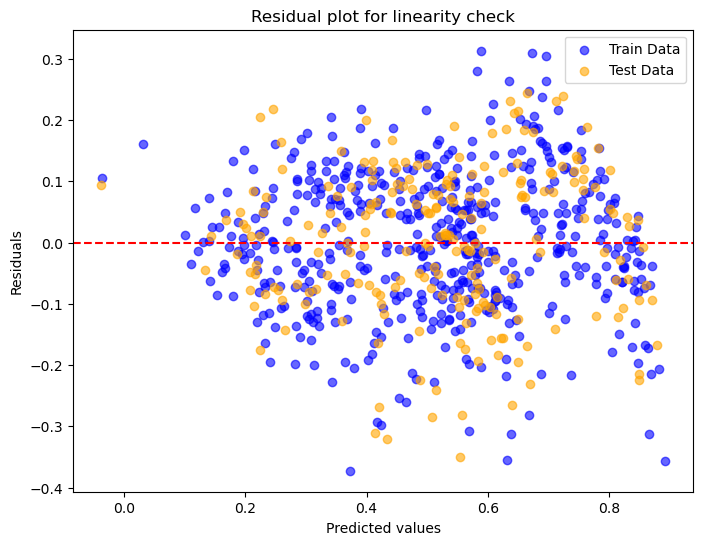

In [77]:
linearity_check_plot(residuals_train=train_res_2, residuals_test=test_res_2, 
                     y_train_pred=y_train_2_pred, y_test_pred=y_test_2_pred)

#### Residual Plot for Linearity Check

In this plot, we can observe:
The plot shows no clear pattern, indicating that the linear regression model's assumptions of linearity are likely met. The residuals are randomly scattered around zero, suggesting that the model's predictions are accurate across the range of predicted values.

In [79]:
independence_check_plot(residuals_train=train_res_2, residuals_test=test_res_2)

Durbin-Watson statistic (Train): 1.9809905481450223
Durbin-Watson statistic (Test): 1.7986585340246506


#### Independence Check 

This plot assesses the independence assumption in regression analysis. The Durbin-Watson statistic values for both the training (1.98) and test (1.79) sets are close to 2, suggesting that the residuals are likely independent and there is no significant autocorrelation present in the data.

Note: A value close to 2 indicates independence, while values significantly less than 2 suggest positive autocorrelation and values significantly greater than 2 suggest negative autocorrelation.

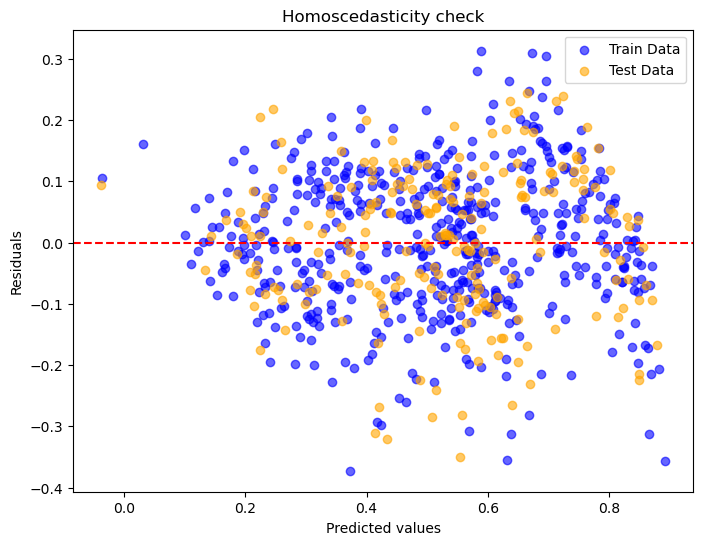

In [81]:
homoscedasticity_check_plot(residuals_train=train_res_2, residuals_test=test_res_2, 
                            y_train_pred=y_train_2_pred, y_test_pred=y_test_2_pred)

#### Homoscedasticity Check

In this plot, we can observe:

The plot shows no clear pattern in the spread of residuals across different predicted values, indicating that the assumption of homoscedasticity is likely met. The residuals appear to have a constant variance, suggesting that the model's error terms are consistent across the range of predicted values.

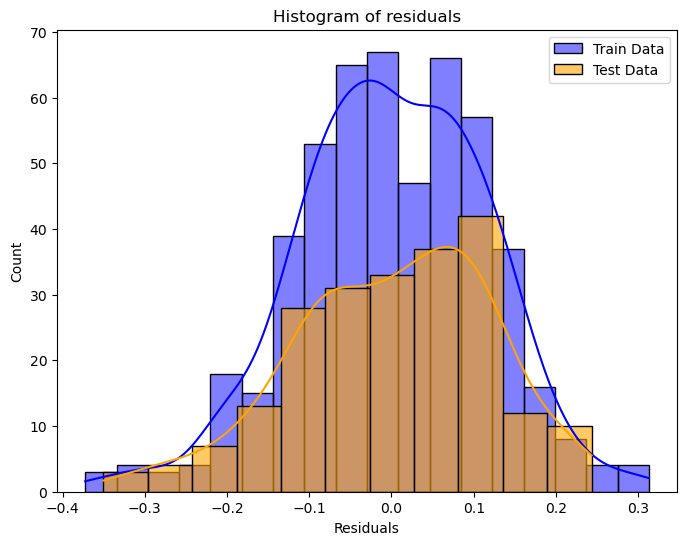

<Figure size 800x600 with 0 Axes>

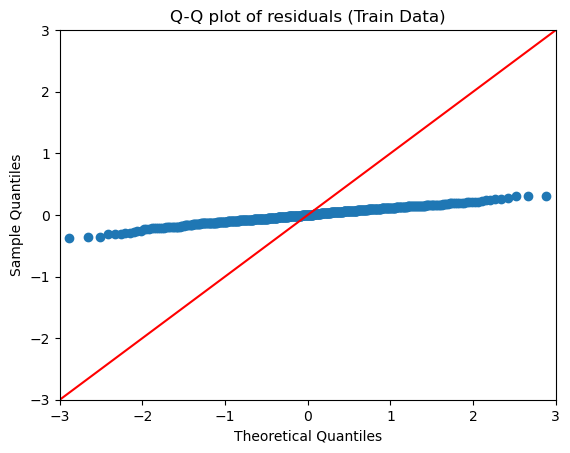

<Figure size 800x600 with 0 Axes>

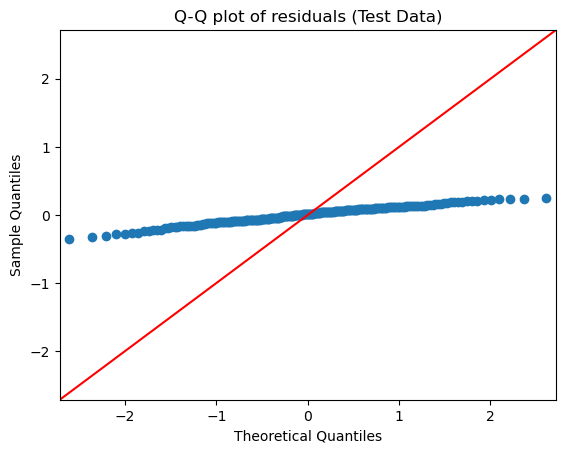

In [83]:
normality_check_plot(residuals_train=train_res_2, residuals_test=test_res_2)

#### Normality check for the Residuals of Train and Test Data

In this plot, we can observe:

-   **Train Data:** The histogram for the train data shows a roughly bell-shaped distribution, suggesting that the residuals are approximately normally distributed. However, there might be a slight skew to the right.
-   **Test Data:** The histogram for the test data also shows a roughly bell-shaped distribution, suggesting that the residuals are approximately normally distributed.

Overall, the histograms suggest that the normality assumption is reasonably met for both the train and test data. However, the slight skew in the train data might indicate that there could be some outliers or non-normality in the data. It's worth further investigating and potentially considering transformations or more robust modeling techniques to address this.

**Q-Q Plot of Residuals (Train Data)**

This Q-Q plot helps assess the normality assumption of the model's residuals. Ideally, the points should follow a straight line. In this plot, we can observe:

-   **Some deviation from normality:** The points deviate slightly from the straight line, especially in the tails. This suggests that the residuals might not be perfectly normally distributed.

**Q-Q Plot of Residuals (Test Data)**

This Q-Q plot helps assess the normality assumption of the model's residuals on the test data. Ideally, the points should follow a straight line. In this plot, we can observe:

-   **Reasonable normality:** The points follow the straight line fairly well, suggesting that the residuals are approximately normally distributed.

Overall, while the normality assumption might not be perfectly met for the train data, the test data seems to have reasonably normally distributed residuals. It's worth considering transformations or more robust modeling techniques if the normality assumption is a major concern.

In [85]:
metrics(y_train_2, y_train_2_pred, y_test_2, y_test_2_pred, X_train_2_rfe)

Features used: ['yr', 'weathersit', 'hum', 'windspeed', 'temp_hum']

Training Set Metrics:
Mean Squared Error (MSE): 0.013052508750662523
Root Mean Squared Error (RMSE): 0.1142475765636301
R-squared Score: 0.7403310875429114

Test Set Metrics:
Mean Squared Error (MSE): 0.014237463729783848
Root Mean Squared Error (RMSE): 0.11932084365182744
R-squared Score: 0.7022340632036265


#### Model Evaluation Metrics

**Interpretation:**

-   **MSE and RMSE:** These metrics measure the average squared difference between the predicted and actual values. Lower values indicate better model performance. In this case, the model performs slightly better on the training set than on the test set, suggesting a slight overfitting.
-   **R-squared:** This metric represents the proportion of variance in the dependent variable explained by the model. Higher values indicate better model fit. The model explains approximately 74% of the variance in the training set and 70% of the variance in the test set.

Overall, the model seems to be performing reasonably well, with good predictive accuracy on both the training and test sets. However, the slight overfitting observed might warrant further investigation and potential regularization techniques to improve the model's generalization performance.

## Model 3

In [88]:
# Define features to use
features_used = ['yr', 'holiday', 'temp', 'hum', 'windspeed', 'Summer', 'Fall',
       'Winter', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'Clear', 'Mist', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'thi', 'wind_chill']

# Select features from training data
X_train_3 = X_train[features_used]
y_train_3 = y_train

# Initialize and fit Linear Regression model 
lm = LinearRegression()
lm.fit(X_train_3, y_train_3)

# Apply Recursive Feature Elimination (RFE)
rfe = RFE(lm, n_features_to_select=15)             # running RFE
rfe = rfe.fit(X_train_3, y_train_3)

# Create list of features with support and ranking, and sort by ranking 
features = list(zip(X_train_3.columns, rfe.support_, rfe.ranking_))
sorted_features = sorted(features, key=lambda x: x[2])

# Display sorted features 
sorted_features

[('yr', True, 1),
 ('holiday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Summer', True, 1),
 ('Fall', True, 1),
 ('Winter', True, 1),
 ('Aug', True, 1),
 ('Sep', True, 1),
 ('Oct', True, 1),
 ('Clear', True, 1),
 ('Mist', True, 1),
 ('thi', True, 1),
 ('wind_chill', True, 1),
 ('Mar', False, 2),
 ('May', False, 3),
 ('Jun', False, 4),
 ('Apr', False, 5),
 ('Fri', False, 6),
 ('Sat', False, 7),
 ('Wed', False, 8),
 ('Thurs', False, 9),
 ('Tues', False, 10),
 ('Mon', False, 11),
 ('Feb', False, 12),
 ('Jul', False, 13),
 ('Nov', False, 14),
 ('Dec', False, 15)]

In [89]:
# Select columns from the original training data that were supported by RFE
col = X_train_3.columns[rfe.support_]

# Create a new DataFrame with the selected columns
X_train_3_rfe = X_train_3[col]

# Display the first few rows of the new DataFrame
display(X_train_3_rfe.head())

,yr,holiday,temp,hum,windspeed,Summer,Fall,Winter,Aug,Sep,Oct,Clear,Mist,thi,wind_chill
576,1,0,0.815169,0.725633,0.264686,0,1,0,0,0,0,1,0,0.862846,0.815757
426,1,0,0.442393,0.640189,0.255342,0,0,0,0,0,0,0,1,0.424582,0.444538
728,1,0,0.245101,0.498067,0.663106,0,0,0,0,0,0,1,0,0.220367,0.212858
482,1,0,0.395666,0.504508,0.188475,1,0,0,0,0,0,0,1,0.370164,0.404535
111,0,0,0.345824,0.751824,0.380981,1,0,0,0,0,0,0,1,0.316816,0.337349


In [90]:
# Add a constant to the features DataFrame
X_train_3_rfe = sm.add_constant(X_train_3_rfe)

# Fit the OLS regression model
lm = sm.OLS(y_train_3,X_train_3_rfe).fit() 

# Print the summary of the regression model and VIF values
print(lm.summary())
vif_calc(X_train_3_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     177.5
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          7.89e-188
Time:                        14:28:57   Log-Likelihood:                 511.83
No. Observations:                 510   AIC:                            -991.7
Df Residuals:                     494   BIC:                            -923.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0317      0.047     -0.667      0.5

In [91]:
# Drop the 'thi' column from the features DataFrame because of High VIF
X_train_3_rfe = X_train_3_rfe.drop(["thi"], axis=1)

lm = sm.OLS(y_train_3,X_train_3_rfe).fit() 
print(lm.summary())
vif_calc(X_train_3_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.7
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.46e-188
Time:                        14:28:57   Log-Likelihood:                 510.84
No. Observations:                 510   AIC:                            -991.7
Df Residuals:                     495   BIC:                            -928.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.043     -0.090      0.9

In [92]:
# Drop the 'wind_chill' column from the features DataFrame because of High VIF
X_train_3_rfe = X_train_3_rfe.drop(["wind_chill"], axis=1)

lm = sm.OLS(y_train_3,X_train_3_rfe).fit() 
print(lm.summary())
vif_calc(X_train_3_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     204.6
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.07e-189
Time:                        14:28:57   Log-Likelihood:                 510.77
No. Observations:                 510   AIC:                            -993.5
Df Residuals:                     496   BIC:                            -934.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.043     -0.050      0.9

In [93]:
# Drop the 'Fall' column from the features DataFrame because of High VIF and High p-value
X_train_3_rfe = X_train_3_rfe.drop(["Fall"], axis=1)

lm = sm.OLS(y_train_3,X_train_3_rfe).fit() 
print(lm.summary())
vif_calc(X_train_3_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     221.3
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.49e-190
Time:                        14:28:57   Log-Likelihood:                 510.00
No. Observations:                 510   AIC:                            -994.0
Df Residuals:                     497   BIC:                            -938.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.043      0.013      0.9

In [94]:
# Drop the 'Mist' column from the features DataFrame because of High VIF
X_train_3_rfe = X_train_3_rfe.drop(["Mist"], axis=1)

lm = sm.OLS(y_train_3,X_train_3_rfe).fit() 
print(lm.summary())
vif_calc(X_train_3_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     213.4
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.68e-180
Time:                        14:28:57   Log-Likelihood:                 483.36
No. Observations:                 510   AIC:                            -942.7
Df Residuals:                     498   BIC:                            -891.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2125      0.033      6.361      0.0

In [95]:
# Drop the 'Oct' column from the features DataFrame because of High p-value
X_train_3_rfe = X_train_3_rfe.drop(["Oct"], axis=1)

lm = sm.OLS(y_train_3,X_train_3_rfe).fit() 
print(lm.summary())
vif_calc(X_train_3_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     234.2
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.61e-181
Time:                        14:28:57   Log-Likelihood:                 482.44
No. Observations:                 510   AIC:                            -942.9
Df Residuals:                     499   BIC:                            -896.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2075      0.033      6.246      0.0

### Prediction

In [97]:
# Predict the training set using the fitted model
y_train_3_pred = lm.predict(X_train_3_rfe)

# Calculate the residuals for the training set
train_res_3 = y_train_3 - y_train_3_pred

In [98]:
# Set the test data for the second model
y_test_3 = y_test_1

In [99]:
# Select the same features as used in training (excluding the constant)
X_test_3 = X_test[X_train_3_rfe.columns.to_list()[1:]]
X_test_3 = sm.add_constant(X_test_3)
y_test_3_pred = lm.predict(X_test_3)

# Calculate the residuals for the test set
test_res_3 = y_test_3 - y_test_3_pred

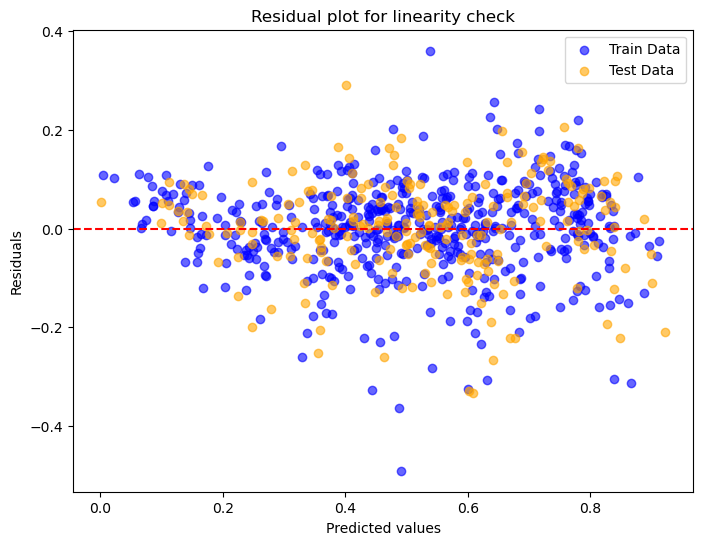

In [100]:
linearity_check_plot(residuals_train=train_res_3, residuals_test=test_res_3, 
                     y_train_pred=y_train_3_pred, y_test_pred=y_test_3_pred)

#### Residual Plot for Linearity Check

In this plot, we can observe:

The residual plot shows that residuals are randomly scattered around zero, indicating that the model likely has a good linear fit without systematic patterns. The distribution of points suggests homoscedasticity, supporting the assumption of constant variance in errors across predicted values.

In [102]:
independence_check_plot(residuals_train=train_res_3, residuals_test=test_res_3)

Durbin-Watson statistic (Train): 2.0584161359551953
Durbin-Watson statistic (Test): 1.8066519419406304


#### Independence Check

The Durbin-Watson statistics for both training (2.05) and test (1.81) data are close to 2, indicating minimal autocorrelation in the residuals. This suggests that the residuals are likely independent, satisfying the assumption of independence in the model.

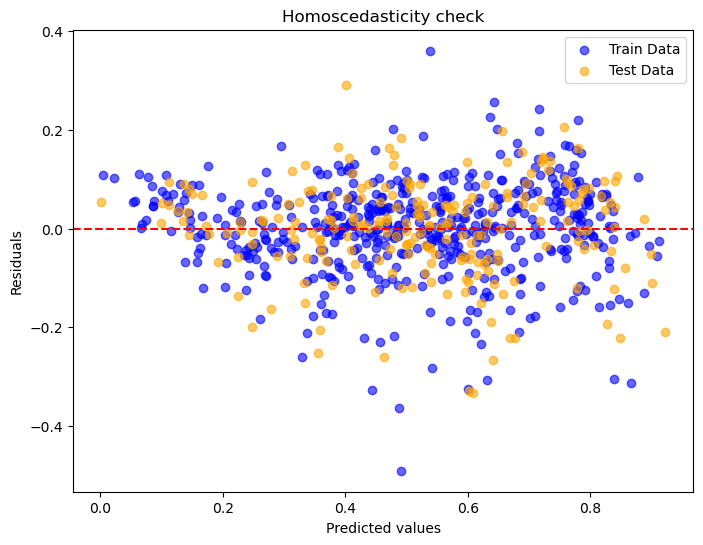

In [104]:
homoscedasticity_check_plot(residuals_train=train_res_3, residuals_test=test_res_3, 
                            y_train_pred=y_train_3_pred, y_test_pred=y_test_3_pred)

#### Homoscedasticity Check

In this plot, we can observe:

The homoscedasticity check shows residuals scattered evenly around the horizontal axis without a clear pattern, suggesting constant variance across predicted values. This supports the assumption of homoscedasticity, indicating that error terms are similarly distributed across all levels of the predictor.

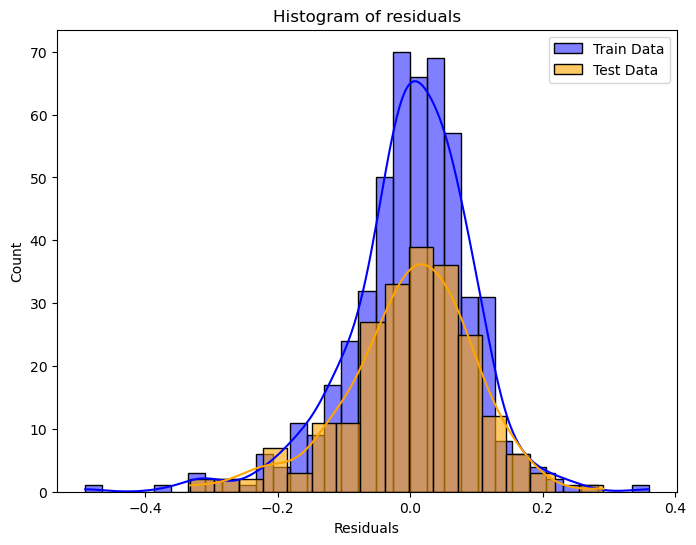

<Figure size 800x600 with 0 Axes>

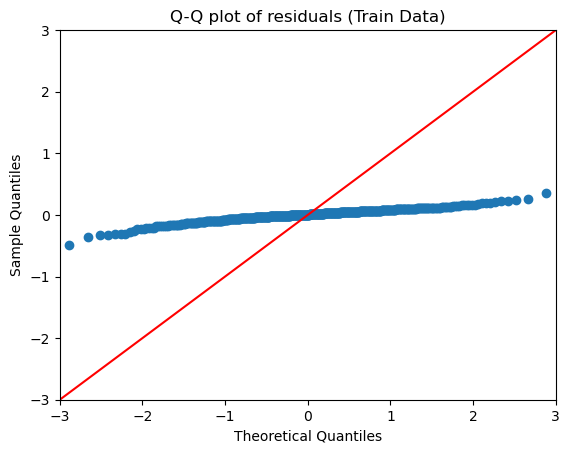

<Figure size 800x600 with 0 Axes>

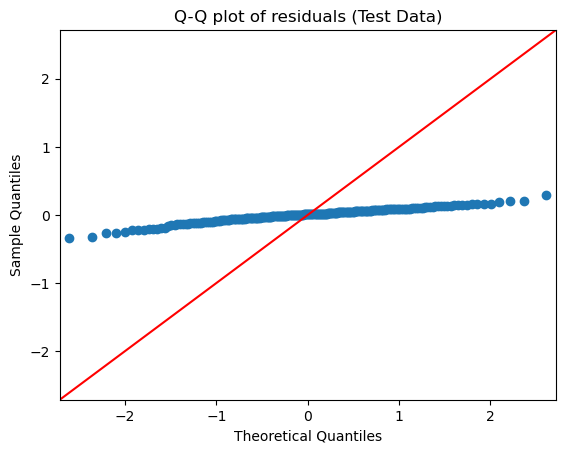

In [106]:
normality_check_plot(residuals_train=train_res_3, residuals_test=test_res_3)

#### Histogram of Residuals

In this plot, we can observe:

The histogram of residuals for both training and test data appears approximately normally distributed around zero, indicating that the normality assumption of residuals is likely met. This suggests that the model errors are symmetrically distributed, enhancing the reliability of inference.


**Q-Q Plot of Residuals (Train Data)**

The Q-Q plot shows that the residuals for the training data deviate slightly from the theoretical line, indicating minor departures from normality, particularly in the tails. However, the points are close to the line, suggesting that the normality assumption is reasonably satisfied for most of the data.

**Q-Q Plot of Residuals (Test Data)**

The Q-Q plot for the test data shows residuals mostly aligning with the theoretical line, indicating that the residuals are approximately normally distributed. There is a slight deviation in the tails, but overall, the normality assumption is reasonably met.

In [108]:
metrics(y_train_3, y_train_3_pred, y_test_3, y_test_3_pred, X_train_3_rfe)

Features used: ['yr', 'holiday', 'temp', 'hum', 'windspeed', 'Summer', 'Winter', 'Aug', 'Sep', 'Clear']

Training Set Metrics:
Mean Squared Error (MSE): 0.008828094188165991
Root Mean Squared Error (RMSE): 0.09395793839887076
R-squared Score: 0.8243723363300982

Test Set Metrics:
Mean Squared Error (MSE): 0.009475747197886164
Root Mean Squared Error (RMSE): 0.09734344969172894
R-squared Score: 0.8018218135775352


**Interpretation:**

-   **MSE and RMSE:** These metrics measure the average squared difference between the predicted and actual values. Lower values indicate better model performance. In this case, the model performs slightly better on the training set than on the test set, suggesting a slight overfitting.
-   **R-squared:** This metric represents the proportion of variance in the dependent variable explained by the model. Higher values indicate better model fit. The model explains approximately 82% of the variance in the training set and 80% of the variance in the test set.

Overall, the model seems to be performing reasonably well, with good predictive accuracy on both the training and test sets.

## Linear Equation based on Model 3

To form the linear equation for predicting bike demand (`cnt`), use the regression coefficients from the model output. The general linear equation for multiple linear regression is:

cnt = const + (coef_1 \* Feature_1) + (coef_2 \* Feature_2) + \dots + (coef_n \* Feature_n)

So, the equation will look like:

> cnt = 0.2075 + (0.2307 \* yr) - (0.0897 \* holiday) + (0.5378 \* temp) - (0.2227 \* hum) - (0.2113 \* windspeed) + (0.1081 \* Summer) + (0.1428 \* Winter) + (0.0610 \* Aug) + (0.1225 \* Sep) + (0.0592 \* Clear)

##### Interpretation of the Equation:

- Each coefficient (`coef`) represents the effect of that variable on `cnt`, holding all other variables constant.

- **Example Interpretation:** A 1-unit increase in `temp` (temperature) is associated with an increase in bike demand (`cnt`) by approximately `0.5378` units, assuming all other factors remain constant.

This equation can now be used to predict `cnt` based on the values of these features.

>                                                                                   **Contributor:**
>                                                                                   Sowmily Dutta (github.com/sowmilydutta)